# PIP INSTALL

In [ ]:
!pip install --upgrade fastai
!pip install wget
!pip install torchsummary
!pip install pytorch_ssim
!pip install piqa
!pip install kornia

     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 247kB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=44b97bbd6263b5b4c59b4a1b9e700834a6ced9239a5223370e47f5f7ad599bd9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully bui

# IMPORTS

In [ ]:
import os
import cv2
import tqdm
import h5py
import wget
import torch
import numpy as np
import torch.nn as nn
from kornia import losses
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from prettytable import PrettyTable
from fastai.layers import ConvLayer
from torch.utils.data import Dataset,DataLoader

# IMAGE DATASET

In [ ]:
url="http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat"
filename=wget.download(url)

KeyboardInterrupt: ignored

In [ ]:
class Image_Dataset(Dataset):
    def __init__(self,images,masks,image_size, CUDA):
        self.images=images
        self.masks=masks
        self.image_size=image_size
        self.CUDA=CUDA
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        if self.CUDA:
            FloatTensor=torch.cuda.FloatTensor()
        else:
            FloatTensor=torch.FloatTensor()
        image=np.transpose(self.images[idx],(2,1,0))
        mask=np.floor(np.transpose(self.masks[idx],(1,0)))        
        image=cv2.resize(image,(self.image_size,self.image_size))
        mask=cv2.resize(mask,(self.image_size,self.image_size))
        image = np.transpose(image,(2,0,1))
        X = FloatTensor(image)
        y = FloatTensor(np.expand_dims(mask,axis=0))
        return X,y

# LOSS

In [ ]:
class Gradient_Net(nn.Module):
  def __init__(self):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    super(Gradient_Net, self).__init__()
    kernel_x = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]
    kernel_x = torch.FloatTensor(kernel_x).unsqueeze(0).unsqueeze(0).to(device)
    kernel_y = [[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]]
    kernel_y = torch.FloatTensor(kernel_y).unsqueeze(0).unsqueeze(0).to(device)
    self.weight_x = nn.Parameter(data=kernel_x, requires_grad=False)
    self.weight_y = nn.Parameter(data=kernel_y, requires_grad=False)

  def forward(self, x):
    grad_x = F.conv2d(x, self.weight_x)
    grad_y = F.conv2d(x, self.weight_y)
    return grad_x,grad_y

class Loss:
    
    @classmethod
    def mse_loss(cls,prediction, target):
        loss = F.mse_loss(prediction, target)
        return loss
    
    @classmethod
    def edge_loss(cls,y_pred,y_true):
      gradients = Gradient_Net()
      dy_true, dx_true = gradients(y_true)
      dy_pred, dx_pred = gradients(y_pred)
      l_edges = torch.mean(torch.abs(dy_pred - dy_true) + torch.abs(dx_pred - dx_true))
      return l_edges
  
    @classmethod
    def depth_loss(cls,y_pred,y_true):
      loss = nn.L1Loss()
      l_depth = loss(y_pred,y_true)
      return l_depth
  
    @classmethod
    def ssim_loss(cls,y_pred,y_true):
      ssim_loss = losses.ssim_loss(y_pred, y_true, 5,10.0)
      return ssim_loss
  
    @classmethod
    def total_loss(cls,y_pred,y_true):
      edge_loss = cls.edge_loss(y_pred,y_true)
      depth_loss = cls.depth_loss(y_pred,y_true)
      ssim_loss = cls.ssim_loss(y_pred,y_true)
      mse_loss = cls.mse_loss(y_pred,y_true)
      total_loss = 1.0*edge_loss  + 0.1*depth_loss  + ssim_loss
      return total_loss


# UTILS

In [ ]:
class Utils:
    @classmethod
    def get_loader(cls,images,masks, image_size,batch_size,num_workers,CUDA):
        """Builds and returns Dataloader."""

        dataset = Image_Dataset(images,masks,image_size =image_size,CUDA=CUDA)
        data_loader = DataLoader(dataset=dataset,batch_size=batch_size,
                                 shuffle=True,num_workers=num_workers)
        return data_loader
    
    @classmethod
    def load_data(cls,filename,fields):
        f=h5py.File(filename,"r")
        images=f[fields[0]]
        ground_truth=f[fields[1]]
        return images,ground_truth
    
    @classmethod
    def train_val_split(cls,filename,fields,train_size):
        images,ground_truth=cls.load_data(filename,fields)
        train_images=images[:train_size]
        train_ground_truth=ground_truth[:train_size]
        val_images=images[train_size:]
        val_ground_truth=ground_truth[train_size:]
        return{"train_data":[train_images,train_ground_truth],
               "val_data":[val_images,val_ground_truth]}
    
    @classmethod
    def print_metrics(cls,avg_loss):
        t = PrettyTable(['Parameter', 'Value'])
        t.add_row(['Avg_Loss', avg_loss])
        print(t)
        return
    
    @classmethod
    def show_batch(cls,dl,batch):
        j=0
        for images, masks in dl:
            j+=1
            images=images.view(batch*15,224,224,3).contiguous()
            masks=masks.view(batch*15,224,224).contiguous()
            for i in range(batch*15):
                plt.imsave(os.path.join("batch_"+str(j),
                                        "batch_images"+str(i)+".png"),
                           np.array(images[i].detach().numpy(),dtype='uint8'))
                plt.imsave(os.path.join("batch_"+str(j),
                                        "batch_masks"+str(i)+".png"),
                           masks[i].detach().numpy())
        
            break
        return
    
    @classmethod
    def shut_down_decoder(cls,model):
        i=0
        for parameter in model.parameters():
            parameter.requires_grad = True
            i+=1
            if(i==108):
                break
        i=0
        for parameter in model.parameters():
            if parameter.requires_grad :
                print(i,"True",parametaer.data.shape)
            else:
                print(i,"False",parameter.shape)
            i+=1
        return 
    

# DENSE-NETS

In [1]:
class _DenseLayer(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(_DenseLayer,self).__init__()
    self.norm1 = nn.BatchNorm2d(num_features=in_channels)
    self.relu1 = nn.ReLU()
    self.conv1 = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels*4,
                          kernel_size=1,stride=1,
                          padding=0,bias=False)
    self.norm2 = nn.BatchNorm2d(num_features=out_channels*4)
    self.relu2 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=out_channels*4,
                          out_channels=out_channels,
                          kernel_size=3,stride=1,
                          padding=1,bias=False)
  
  def forward(self,x):
      y = self.norm1(x)
      y = self.relu1(y)
      y = self.conv1(y)
      y = self.norm2(y)
      y = self.relu2(y)
      y = self.conv2(y)
      x = torch.cat([x,y],dim=1)
      return x

class _DenseBlock(nn.Module):
  def __init__(self,in_channels,out_channels,num_repeat):
    super(_DenseBlock, self).__init__()
    self.denseblock = self.dense_block(in_channels,out_channels,num_repeat)
  
  def dense_block(self,in_channels,out_channels,num_repeat):
    dense_layers = []
    for i in range(1,num_repeat+1):
      dense_layers.append(("denselayer"+str(i),_DenseLayer(in_channels=in_channels,
                                    out_channels=out_channels)))
      in_channels+=out_channels
    return nn.Sequential(OrderedDict(dense_layers))

  def forward(self,x):
    return self.denseblock(x)

class _Transition(nn.Module):
  def __init__(self,in_channels,out_channels):
    super(_Transition,self).__init__()
    self.norm = nn.BatchNorm2d(num_features=in_channels)
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=1,stride=1,
                          padding=0,bias=False)
    self.pool = nn.AvgPool2d(kernel_size=2,stride=2)

  def forward(self,x):
    x=self.norm(x)
    x=self.relu(x)
    x=self.conv(x)
    x=self.pool(x)
    return x

class Global():
  def __init__(self):
    self.last_out_channels=None
global_ = Global()

class Computation():

  @classmethod
  def cal_channels(cls,in_channels,out_channels,num_repeat):
    for i in range(num_repeat):
      in_channels += out_channels
    return in_channels


NameError: name 'nn' is not defined

In [ ]:
class DenseNets(nn.Module):
  def __init__(self,input_channels,encoder_arch):
    super(DenseNets,self).__init__()
    self.arch_parameters=self.find_arch_parameters(encoder_arch)
    self.in_channels = self.arch_parameters["initial_channels"]
    self.intermediate_channels = self.arch_parameters["intermediate_channels"]
    self.layers_lengths = self.arch_parameters["layers_length"]

    self.conv0 = nn.Conv2d(in_channels=input_channels,
                          out_channels=self.in_channels,kernel_size=7,
                          stride=2,padding=3,bias=False)
    self.norm0 = nn.BatchNorm2d(num_features=self.in_channels)
    self.relu0 = nn.ReLU()
    self.skip0_channels = self.in_channels

    self.maxpool0 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
    self.skip1_channels = self.in_channels

    self.denseblock1 = _DenseBlock(in_channels=self.in_channels,
                                   out_channels=self.intermediate_channels,
                                   num_repeat=self.layers_lengths[0])
    self.in_channels = Computation.cal_channels(in_channels=self.in_channels,
                                                out_channels=self.intermediate_channels,
                                                num_repeat=self.layers_lengths[0])
    self.transition1 = _Transition(in_channels=self.in_channels,
                                   out_channels=self.in_channels//2)
    self.skip2_channels = self.in_channels//2
    
    self.denseblock2 = _DenseBlock(in_channels=self.in_channels//2,
                                   out_channels=self.intermediate_channels,
                                   num_repeat=self.layers_lengths[1])
    self.in_channels = Computation.cal_channels(in_channels=self.in_channels//2,
                                                out_channels=self.intermediate_channels,
                                                num_repeat=self.layers_lengths[1])
    self.transition2 = _Transition(in_channels=self.in_channels,
                                   out_channels=self.in_channels//2)
    self.skip3_channels = self.in_channels//2
    
    self.denseblock3 = _DenseBlock(in_channels=self.in_channels//2,
                                   out_channels=self.intermediate_channels,
                                   num_repeat=self.layers_lengths[2])
    self.in_channels = Computation.cal_channels(in_channels=self.in_channels//2,
                                                out_channels=self.intermediate_channels,
                                                num_repeat=self.layers_lengths[2])
    self.transition3 = _Transition(in_channels=self.in_channels,
                                   out_channels=self.in_channels//2)
    self.skip4_channels = self.in_channels//2
    
    self.denseblock4 = _DenseBlock(in_channels=self.in_channels//2,
                                   out_channels=self.intermediate_channels,
                                   num_repeat=self.layers_lengths[3])
    self.in_channels = Computation.cal_channels(in_channels=self.in_channels//2,
                                                out_channels=self.intermediate_channels,
                                                num_repeat=self.layers_lengths[3])
    
    self.norm5 = nn.BatchNorm2d(num_features=self.in_channels)

  def find_arch_parameters(self,encoder_arch):
    if encoder_arch == "densenet121":
      return {"initial_channels":64,
              "intermediate_channels":32,
              "layers_length":[6,12,24,16]
             }     
    elif encoder_arch == "densenet161":
      return {"initial_channels":96,
              "intermediate_channels":48,
              "layers_length":[6,12,36,24]
             }   
    elif encoder_arch == "densenet169":
      return {"initial_channels":64,
              "intermediate_channels":32,
              "layers_length":[6,12,32,32]
             }
    elif encoder_arch == "densenet201":
      return {"initial_channels":64,
              "intermediate_channels":32,
              "layers_length":[6,12,48,32]
             }
    elif encoder_arch == "densenet264":
      return {"initial_channels":64,
              "intermediate_channels":32,
              "layers_length":[6,12,64,48]
             }
    
  def forward(self,x):
    x = self.conv0(x)
    x = self.norm0(x)
    x0 = self.relu0(x)
    x1 = self.maxpool0(x0)
    x = self.denseblock1(x1)
    x2 = self.transition1(x)
    x = self.denseblock2(x2)
    x3 = self.transition2(x)
    x = self.denseblock3(x3)
    x4 = self.transition3(x)
    x = self.denseblock4(x4)
    x = self.norm5(x)
    return x0,x1,x2,x3,x4,x

# ATTENTION-NET

In [ ]:
class AttentionUnit(nn.Module):
    def __init__(self,in_channels):
        super(AttentionUnit,self).__init__()
        self.relu=nn.LeakyReLU()
        self.conv=nn.Conv2d(in_channels,1,kernel_size=1,stride=1,padding=0)
        self.sigmoid=nn.Sigmoid()
    def forward(self,x):
      #x_=torch.add(x,g)
      x_=self.relu(x)
      x_=self.conv(x)
      x_=self.sigmoid(x)
      x=torch.mul(x,x_)
      return x

# UNET Modules

In [ ]:
class BottleNeck(nn.Module):
  def __init__(self,in_channels):
    super(BottleNeck,self).__init__()
    self.bottle_conv1 = nn.Conv2d(in_channels=in_channels,out_channels=1024,
                          kernel_size=3,stride=1,padding=1)
    self.bottle_conv2=nn.Conv2d(1024,512,kernel_size=3,stride=1,padding=1)

  def forward(self,x):
    x=self.bottle_conv1(x)
    x=self.bottle_conv2(x)
    return x

class UnetBlock(nn.Module):
  def __init__(self,in_channels,skip_channels):
    super(UnetBlock,self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.attention = AttentionUnit(skip_channels)
    self.conv1 = nn.Conv2d(in_channels=in_channels+skip_channels,
                          out_channels=(in_channels+skip_channels)//2,
                          kernel_size=3,stride=1,
                          padding=1)
    self.conv2 = nn.Conv2d(in_channels=(in_channels+skip_channels)//2,
                           out_channels=(in_channels+skip_channels)//4,
                           kernel_size=3,stride=1,
                           padding=1)
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self,skip,x):
    x = self.upsample(x)
    skip = self.attention(skip) 
    x = torch.cat([skip,x],dim=1)
    x = self.conv1(x)
    x = self.leaky_relu(x)
    x = self.conv2(x)
    x = self.leaky_relu(x)
    return x
    

In [ ]:
class DenseUnet(nn.Module):
  def __init__(self,encoder_arch,input_channels):
    super(DenseUnet,self).__init__()
    self.densenet_encoder = DenseNets(input_channels=input_channels,
                                      encoder_arch=encoder_arch)
    self.densenet_encoder.load_state_dict(torch.load("/content/drive/MyDrive/DensetNet_169_encoder_model.pth"))
    self.bottleneck = BottleNeck(in_channels=self.densenet_encoder.in_channels)
    self.conv1 = nn.Conv2d(in_channels=self.densenet_encoder.in_channels+512,
                          out_channels=self.densenet_encoder.in_channels+512,kernel_size=3,
                          stride=1,padding=1)
    self.conv2 = nn.Conv2d(in_channels=self.densenet_encoder.in_channels+512+self.densenet_encoder.skip4_channels,
                          out_channels=self.densenet_encoder.in_channels+512,kernel_size=3,
                          stride=1,padding=1)
    
    self.in_channels = self.densenet_encoder.in_channels+512
    self.unet_block1 = UnetBlock(in_channels=self.densenet_encoder.in_channels+512,
                                 skip_channels=self.densenet_encoder.skip3_channels)
    
    self.in_channels = (self.in_channels+self.densenet_encoder.skip3_channels)//4
    self.unet_block2 = UnetBlock(in_channels=self.in_channels,
                                 skip_channels=self.densenet_encoder.skip2_channels)
    
    self.in_channels = (self.in_channels+self.densenet_encoder.skip2_channels)//4
    self.unet_block3 = UnetBlock(in_channels=self.in_channels,
                                 skip_channels=self.densenet_encoder.skip1_channels)
    
    self.in_channels = (self.in_channels+self.densenet_encoder.skip1_channels)//4
    self.unet_block4 = UnetBlock(in_channels=self.in_channels,
                                 skip_channels=self.densenet_encoder.skip0_channels)
    
    self.in_channels = (self.in_channels+self.densenet_encoder.skip0_channels)//4
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.upsample_conv = ConvLayer(self.in_channels,64,ks=3,stride=1,padding=None,
                                act_cls=None ,bias=None)
    self.out_conv = nn.Conv2d(in_channels=3+64,out_channels=1,kernel_size=1,
                              stride=1,padding=0)
    
  def forward(self,input_image):
    x0,x1,x2,x3,x4,x = self.densenet_encoder(input_image)
    x_ = self.bottleneck(x)
    x_ = torch.cat([x,x_],dim=1)
    x_ = self.conv1(x_)
    x_ = torch.cat([x4,x_],dim=1)
    x_ = self.conv2(x_)
    x_ = self.unet_block1(x3,x_)
    x_ = self.unet_block2(x2,x_)
    x_ = self.unet_block3(x1,x_)
    x_ = self.unet_block4(x0,x_)
    x_ = self.upsample(x_)
    x_ = self.upsample_conv(x_)
    x_ = torch.cat([input_image,x_],dim=1)
    out = self.out_conv(x_)
    return out

# TRAINING

In [ ]:
class Trainer:
    def __init__(self, device, CUDA, dataset_path, output_dir, image_size, batch_size, model, epochs, lr, best_loss):
        self.device = device
        self.CUDA = CUDA
        self.dataset_path = dataset_path
        self.output_dir = output_dir
        self.out_weight_dir = os.path.join(self.output_dir, "weights")
        if not os.path.exists(self.out_weight_dir):
            os.mkdir(self.out_weight_dir)
        self.image_size=image_size
        self.batch_size=batch_size
        self.model = model.to(self.device)
        self.epochs=epochs
        self.lr=lr
        self.best_loss=best_loss
        
        self.data = Utils.train_val_split(filename=self.dataset_path,
                                          fields=["images","depths"],
                                          train_size=1200)
        self.train_dataset = self.data["train_data"]
        self.valid_dataset = self.data["val_data"]
        self.train_dataloader=Utils.get_loader(images=self.train_dataset[0],
                                               masks=self.train_dataset[1],
                                               image_size=self.image_size,
                                               batch_size=self.batch_size,
                                               num_workers=0,CUDA=self.CUDA)
        self.valid_dataloader=Utils.get_loader(images=self.valid_dataset[0],
                                               masks=self.valid_dataset[1],
                                               image_size=self.image_size,
                                               batch_size=self.batch_size,
                                               num_workers=0,CUDA=self.CUDA)
        self.optimizer=torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        
    def fit(self):
        for epoch in tqdm.tqdm(range(self.epochs)):
            #Training Phase
            self.model.train()
            train_loss = []
            for i, (images, masks) in enumerate(self.train_dataloader):
                images=images/255
                images.to(self.device)
                masks.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = Loss.total_loss(y_pred=outputs, y_true=masks)
                train_loss.append(loss.item())
                loss.backward()
                self.optimizer.step()
  
            #Validation Phase
            self.model.eval()
            valid_loss = []
            for i, (images, masks) in enumerate(self.valid_dataloader):
                images=images/255
                images.to(self.device)
                masks.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = Loss.total_loss(y_pred=outputs, y_true=masks)
                valid_loss.append(loss.item())
            
            avg_train_loss = np.average(train_loss)
            Utils.print_metrics(avg_train_loss)
            
            avg_valid_loss = np.average(valid_loss)
            Utils.print_metrics(avg_valid_loss)
            
            torch.save(self.model.state_dict(),
                       os.path.join(self.out_weight_dir, "Dense_Depth_model.pth"))
            if(avg_valid_loss<self.best_loss):
                torch.save(self.model.state_dict(), 
                           os.path.join(self.out_weight_dir,f"Dense_Depth_model_loss_{avg_valid_loss}.pth"))
                self.best_loss = avg_valid_loss
        return
    

In [ ]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA = torch.cuda.is_available()
root_dir = "dataset"
dataset_file = ""
dataset_path = os.path.join(root_dir, dataset_file)
output_dir = "outputs"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
weight_dir = ""
model_weights_file = None
image_size = 320
batch_size = 5
epochs = 30
lr = 0.00008
best_loss = 100000

shut_encoder = False

d_encoder_layer_num = {
    "densenet121": 121,
    "densenet161": 161,
    "densenet169": 169,
    "densenet201": 201,
    "densenet264": 264
}
encoder_arch = "densenet169"
input_channels = 3

model = DenseUnet(encoder_arch=encoder_arch,
                  input_channels=input_channels)

if model_weights_file is not None:
    model_path = os.path.join(weight_dir, model_weights_file)
    model.load_state_dict(torch.load(model_path))
else:
    pass


Utils.shut_down_decoder(model=model, 
                        layer_num=d_encoder_layer_num.get(encoder_arch),
                        shut_encoder=shut_encoder)
    
model = model.to(device)
train=Trainer(device=device, CUDA=CUDA, dataset_path=dataset_path, 
              output_dir=output_dir, image_size=image_size, 
              batch_size=batch_size, model=model, epochs=50,
              lr=0.00008, best_loss=best_loss)



  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


RuntimeError: ignored

In [ ]:
train.fit()

# PREDICTION

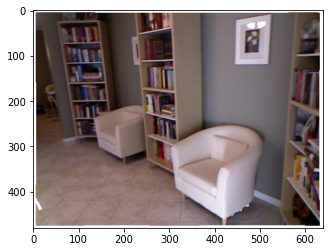

In [ ]:
img = plt.imread("/content/499_image.png")
plt.imshow(img)

In [ ]:
out = model.forward(torch.tensor(np.transpose(img,(2,0,1))).unsqueeze(0).to("cuda:0"))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


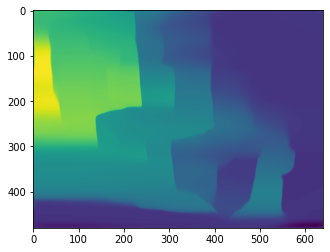

In [ ]:
plt.imshow(np.transpose(np.array(out.detach().cpu())[0],(1,2,0))[:,:,0])

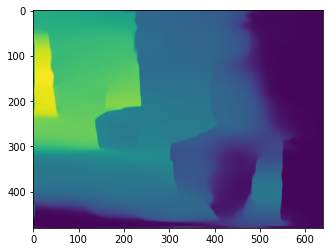

In [ ]:
plt.imshow(np.transpose(np.array(out.detach().cpu())[0],(1,2,0))[:,:,0])